In [1]:
#import packages
from urllib import FancyURLopener
from bs4 import SoupStrainer, BeautifulSoup
import re
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


# Contents
## Scrapping
## Data processing
## Examples and plots

### Scrapping

In [2]:
class MyOpener(FancyURLopener):
    version = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.152 Safari/537.36'
openurl = MyOpener().open

def data_from_page_senadores(url):
    """
    Function to scrap relevant data from election results webpage.
    
    Input url and outputs a dataframe row with a bunch of information from the page.
    """
    
    url = openurl(url)
    page = BeautifulSoup(url.read())
    
    # District
    dist = page.find_all("div", class_="textoAmbitoContainer")[0].p.string[15:]
    # Time
    hora = page.find_all("div", id="fechacorta")[0].p.string[13:18]
    # Date
    fecha = page.find_all("div", id="fechacorta")[0].p.string[23:]
    
    # Observed urns (mesas escrutadas)
    mesas_e = int(filter(unicode.isdigit, page.find_all('div', class_ = 'mesasEscrutadas dch')[0].p.contents[0]))
    # Observed urns (%)
    pmesas_e = float(page.find_all('div', class_ = 'mesasEscrutadas dch')[0].p.span.string[2:-2].replace(',','.'))
    # How many people allowed to vote
    electores = int(filter(unicode.isdigit, page.find_all('div', class_='participacion izq')[1].p.span.string))
    # How many valid votes (used for computing percentages to each party)
    validos = int(filter(unicode.isdigit, page.find_all('tr', class_ = 'validos')[0].find_all('td', class_ = 'vot')[0].string))

    # List of political parties (agrupacion)
    agrup = [x.find_all('td', class_ = 'denom')[0].contents[0] for x in page.find_all("tr", class_="r1 agrup")]
    # List of their votes
    votos = [int(filter(unicode.isdigit, x.find_all('td', class_ = 'vot')[0].string)) for x in page.find_all("tr", class_="r1 agrup")]
    # List of their votes (%)
    pvotos = [float(x.find_all('td', class_ = 'pvot')[0].string[:-1].replace(',','.')) for x in page.find_all("tr", class_="r1 agrup")]

    # Set it up in a pandas dataframe row and return it
    d = [hora, fecha, mesas_e, pmesas_e, electores, validos] + votos + pvotos
    columns = ['hora', 'fecha', 'mesas_e', 'pmesas_e', 'electores', 'validos'] + [str('vot_')+a for a in agrup] + [str('pvot_')+a for a in agrup]
    row = pd.DataFrame(dict(zip(columns, d)), index=[dist])
    
    return row

In [3]:
# There's one url for each district:
urls_senad = ['http://www.resultados.gob.ar/escrutinio/dat02/DSN0'+str(n)+'A.htm'             
        for n in range(2001,2136)]

# Set up a dataframe with the scrapped results
df = pd.DataFrame()
for url in urls_senad:
    new_row = data_from_page_senadores(url)
    df = df.append(new_row)

## Data processing
### Set up dataset

In [15]:
# Keep only columns that you care about
data = df[['fecha', 'hora', 'mesas_e', 'pmesas_e',
           'pvot_CAMBIEMOS BUENOS AIRES', 'pvot_UNIDAD CIUDADANA',
           'vot_CAMBIEMOS BUENOS AIRES', 'vot_UNIDAD CIUDADANA',
           'validos', 'electores']]

#Format time and date columns
data = data.assign(hora = pd.to_datetime(data['hora'], format='%H:%M', infer_datetime_format=True).dt.time,
                   fecha= pd.to_datetime(data['fecha'],format='%d/%m', infer_datetime_format=True).dt.date)

data['time'] = data.apply(lambda r : pd.datetime.combine(r['fecha'],r['hora']),1)
data['time_delta'] = (data['time'] - data['time'].min())  / np.timedelta64(1,'h') #-2/3. + 


In [46]:
#Compute number of non-observed urns from observed urns and it's percentage.
data = data.assign(mesas_NO_e = data.mesas_e / (0.01 * data.pmesas_e) - data.mesas_e)
data.mesas_NO_e = data.mesas_NO_e.round().astype(int)

# Compute average votes per urn
data['vot_PRO_xmesa'] = data['vot_CAMBIEMOS BUENOS AIRES'] / data['mesas_e']
data['vot_UC_xmesa'] = data['vot_UNIDAD CIUDADANA'] / data['mesas_e']

# Linear projection based on votes per urn and non observed urns
data['proy_ventajaUC'] = (1 - 0.01 * data['pmesas_e'])*(data['vot_UNIDAD CIUDADANA'] - data['vot_CAMBIEMOS BUENOS AIRES'])
data['proy_ventajaUC'] = data['proy_ventajaUC'].round().astype(int)

#Rankings by observed urns and allowed voters (electores)
data['rank_escrutada'] = data.pmesas_e.rank()/125.
# data['rank_electores'] = data.electores.rank()/125.

### Exercises
#### Here we do the splitting into quantiles. The data is shown here and can be plotted for example in pie charts for each category.

In [62]:
data['rank_escrutada_cat'] = np.ceil(5*data.rank_escrutada)

df = data.groupby(data['rank_escrutada_cat']).sum()[['vot_CAMBIEMOS BUENOS AIRES',
       'vot_UNIDAD CIUDADANA', 'validos','electores','mesas_NO_e',
    'proy_ventajaUC']]
df

,vot_CAMBIEMOS BUENOS AIRES,vot_UNIDAD CIUDADANA,validos,electores,mesas_NO_e,proy_ventajaUC
rank_escrutada_cat,,,,,,
1.0,940529,1287603,3246131,4526733,862,23434
2.0,757895,798751,2303363,3204565,420,2386
3.0,719905,552544,1832929,2469194,190,-4314
4.0,462664,307742,1150432,1550438,65,-1730
5.0,165117,92555,377207,502983,0,0


#### Randomization: what if non-opened urns were allocated to districts randomly? How much could results deviate?
#### Is it likely that randomly located non-opened urns give a higher value to 'PRO' yellow than to 'UC' blue? (Answer: NO!)

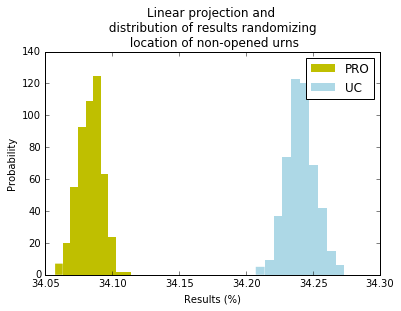

In [63]:
proy_tot_mesas = []

for index, row in data.iterrows():
    proy_mesas = [(row['vot_PRO_xmesa'], row['vot_UC_xmesa']) for i in range((row['mesas_e'] + row['mesas_NO_e']))]
    proy_tot_mesas = proy_tot_mesas + proy_mesas
    
PRO_rand = []
UC_rand = []

for i in range(500):
    sample = random.sample(proy_tot_mesas, data.mesas_e.sum())
    rd_vot_PRO = [round(sum([s[0] for s in sample]))]
    rd_vot_UC = [round(sum([s[1] for s in sample]))]
    PRO_rand= PRO_rand+ rd_vot_PRO
    UC_rand = UC_rand + rd_vot_UC

tot_validos = float(data['validos'].sum())
plt.hist([np.true_divide(100*x,tot_validos) for x in PRO_rand], edgecolor = 'none', color ='y', label = 'PRO')
plt.hist([np.true_divide(100*x,tot_validos) for x in UC_rand ], edgecolor = 'none', color ='lightblue', label = 'UC')
plt.title('Linear projection and \n distribution of results randomizing \n location of non-opened urns')
plt.xlabel('Results (%)')
plt.ylabel('Probability')
plt.legend()
plt.show()

#### Linear projection of non opened urns

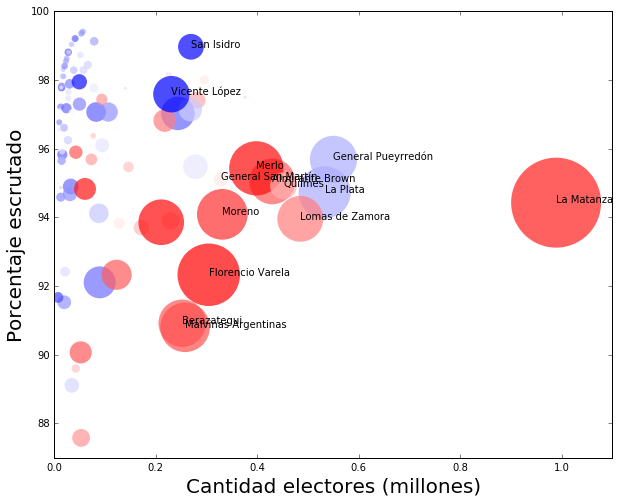

In [32]:
import matplotlib
font = {'size'   : 10}
matplotlib.rc('font', **font)

#Scatter plot variables
x = data.electores*0.000001 #Scale by a million
y = data.pmesas_e

#Show some labels this way. The largest districts plus other labels worth it.
n=list(data.index)
n = [name if name in (list(data.loc[data['mesas_NO_e']>40].index)+[u'Vicente López', u'San Isidro']) else '' for name in n]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y, edgecolors='none', 
            c=(data['vot_UNIDAD CIUDADANA'] - data['vot_CAMBIEMOS BUENOS AIRES'])/data['mesas_e'],
           cmap ='bwr',
           s = 0.9 * abs(data['proy_ventajaUC']),
           alpha = 0.7)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))

plt.xlabel('Cantidad electores (millones)', fontsize=20)
plt.ylabel('Porcentaje escrutado', fontsize=20)


plt.xlim(0, 1.1)
plt.ylim(87, 100)

plt.show()

In [58]:
#See the data of the plot above:
dg = data[['vot_CAMBIEMOS BUENOS AIRES',
       'vot_UNIDAD CIUDADANA', 'mesas_e','mesas_NO_e','proy_ventajaUC']]
dg = dg.assign(Dif_favor_UC = dg['vot_UNIDAD CIUDADANA'] - dg['vot_CAMBIEMOS BUENOS AIRES'])
dg.columns = [u'votos PRO', u'votos UC', u'escru', u'NO escru', u'Difer UC', 'Proy definitivo']
x = dg.sort_values(by = 'NO escru', ascending=False).head(10)
x
# print x.to_latex()

,votos PRO,votos UC,escru,NO escru,Difer UC,Proy definitivo
La Matanza,177770,339139,2678,158,8988,161369
Lomas de Zamora,104338,143020,1306,84,2336,38682
La Plata,156754,99472,1474,82,-3019,-57282
General Pueyrredón,154217,96723,1508,68,-2478,-57494
Malvinas Argentinas,47145,76806,671,68,2729,29661
Florencio Varela,48542,105100,807,67,4338,56558
Berazategui,48215,75632,661,66,2489,27417
Quilmes,107695,123473,1233,66,802,15778
Almirante Brown,81783,128889,1171,61,2332,47106
Moreno,54423,102663,892,56,2851,48240


#### Example plot: PRO does better in smaller districts.

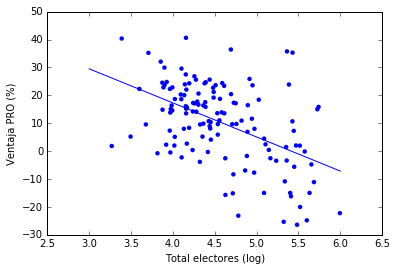

In [61]:
x = np.log10(data.electores)
y = data['pvot_CAMBIEMOS BUENOS AIRES'] - data['pvot_UNIDAD CIUDADANA']

m,b = np.polyfit(x, y, 1)

plt.scatter(x, y, edgecolors='none', c='b')
t = np.arange(3, 7, 1)
plt.plot(t, m * t + b)

plt.xlabel('Total electores (log)')
plt.ylabel('Ventaja PRO (%)')
plt.show()